In [1]:
import pandas as pd
import torch
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, TrainingArguments 
from trl import SFTTrainer  # Import SFTTrainer for instruction-based fine-tuning
from sklearn.model_selection import train_test_split
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
data_path = 'niagara.data'  # Update with your file path
data = pd.read_csv(data_path, sep=';', header=None, names=['Code', 'Description', 'Lien', 'Detail', 'Flag'], on_bad_lines='skip')
data['input'] =   data['Code'] 
data['output'] = data.apply(lambda row: "Cela correspond "+ 
                            ("à l'" if isinstance(row['Description'], str) and row['Description'][0].lower() in 'aeiou' else "au ") + 
                            str(row['Description']) + ". " + str(row['Detail']), axis=1)

# Create a Hugging Face dataset
dataset = Dataset.from_pandas(data[['input', 'output']])

print(dataset[2])

{'input': 'ARC-101', 'output': "Cela correspond au Retrait de lignes dans la table tampon de l’archivage. Ce traitement permet de supprimer des lignes de la table A_ARC_DONNEE à partir des ID des objets qu'elles représentent."}


In [4]:
def create_prompt(sample):
  bos_token = "<s>"
  system_message = """[INST] À partir de la description détaillée fournie, identifiez et donnez le titre exact de la documentation qui correspond à cette description. Si vous n'êtes pas certain de la réponse exacte, fournissez une idée des éléments les plus proches qui pourraient correspondre à la description. Dans le cas où aucune correspondance n'est trouvée ou si vous ne connaissez pas la documentation correspondante, répondez simplement par 'Je ne connais pas cela'."""
  response = sample["output"]
  input = sample["input"]
  eos_token = "</s>"

  full_prompt = ""
  full_prompt += bos_token
  full_prompt += system_message
  full_prompt += "\n" +  response
  full_prompt += "[/INST]"
  full_prompt += input
  full_prompt += eos_token

  return full_prompt

def create_combined_bidirectional_prompt(sample):
    # Définition des parties du prompt
    bos_token = "<s>"
    eos_token = "</s>"
    
    # Instruction pour Titre vers Description
    system_message_title_to_description = "[INST] Donnez la description détaillée correspondant au titre suivant correspondant au titre d'une documentation du porjet SIG."
    title = sample["input"]  # Assurez-vous que 'sample' contient un champ 'title'
    
    # Instruction pour Description vers Titre
    system_message_description_to_title = """[INST] Identifiez et donnez le titre exact de la documentation correspondant à la description suivante. Si vous n'êtes pas certain de la réponse exacte, fournissez une idée des éléments les plus proches qui pourraient correspondre à la description. Dans le cas où aucune correspondance n'est trouvée ou si vous ne connaissez pas la documentation correspondante, répondez simplement par 'Je ne connais pas cela'."""
    description = sample["output"]  # Assurez-vous que 'sample' contient un champ 'description'
    
    # Création et combinaison des deux prompts
    combined_prompt = f"{bos_token}{system_message_title_to_description}\n Titre: {title} [/INST] \n Description: {description}{eos_token} "
    # combined_prompt += f"{system_message_description_to_title}\n Description: {description} [/INST] \n Titre: {title} "
    
    return combined_prompt


In [5]:
create_combined_bidirectional_prompt(dataset[2])

"<s>[INST] Donnez la description détaillée correspondant au titre suivant correspondant au titre d'une documentation du porjet SIG.\n Titre: ARC-101 [/INST] \n Description: Cela correspond au Retrait de lignes dans la table tampon de l’archivage. Ce traitement permet de supprimer des lignes de la table A_ARC_DONNEE à partir des ID des objets qu'elles représentent.</s> "

In [6]:
model_id = "mistralai/Mixtral-8x7B-Instruct-v0.1"

In [7]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import torch

nf4_config = BitsAndBytesConfig(
   load_in_4bit=True,
   bnb_4bit_quant_type="nf4",
   bnb_4bit_use_double_quant=True,
   bnb_4bit_compute_dtype=torch.bfloat16
)

In [8]:
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map='auto',
    quantization_config=nf4_config,
    use_cache=False,
    attn_implementation="flash_attention_2"

)

Loading checkpoint shards:   0%|          | 0/19 [00:00<?, ?it/s]

In [9]:
tokenizer = AutoTokenizer.from_pretrained(model_id)

tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

In [10]:
def generate_response(prompt, model):
    
    encoded_input = tokenizer(prompt,  return_tensors="pt", add_special_tokens=True)
    model_inputs = encoded_input.to('cuda')
    
    generated_ids = model.generate(**model_inputs,
                                 max_new_tokens=1024,
                                 do_sample=True,
                                 pad_token_id=tokenizer.eos_token_id)
    
    decoded_output = tokenizer.batch_decode(generated_ids)
    
    return decoded_output[0].replace(prompt, "")

In [11]:
prompt="""[INST] Donnez la description détaillée correspondant au titre suivant.\n Titre: ARC-101 [/INST]"""

generate_response(prompt, model)

'<s>  Le titre "ARC-101" est plutôt générique et peut correspondre à différentes choses selon le contexte. Voici quelques exemples de description détaillée possible en fonction des domaines d\'application :\n\n1. Dans le domaine de la construction et de l\'architecture, ARC-101 pourrait se référer à un type de béton renforcé ou à un système de poutres en acier utilisés dans la construction de bâtiments ou d\'infrastructures.\n2. En électronique et en ingénierie, ARC-101 pourrait être le nom d\'un circuit intégré ou d\'un composant spécifique utilisé dans l\'assemblage de cartes électroniques.\n3. Dans le domaine de la chimie et de la physique, ARC-101 pourrait être le nom d\'une molécule ou d\'un matériau spécifique utilisé dans la recherche scientifique ou dans l\'industrie.\n4. Dans le domaine de la formation et de l\'éducation, ARC-101 pourrait être le code ou le nom d\'un cours d\'introduction à l\'architecture ou à l\'ingénierie, offrant les bases théoriques et pratiques de la con

In [12]:
def tokenize_prompts(prompt):
    return tokenizer(create_combined_bidirectional_prompt(prompt))

In [13]:
train_test_split = dataset.train_test_split(test_size=0.1)  # Séparer les données en set d'entraînement et de test
tokenized_train_dataset = dataset.map(tokenize_prompts)
tokenized_val_dataset = train_test_split['test'].map(tokenize_prompts)


Map:   0%|          | 0/1842 [00:00<?, ? examples/s]

Map:   0%|          | 0/185 [00:00<?, ? examples/s]

2027


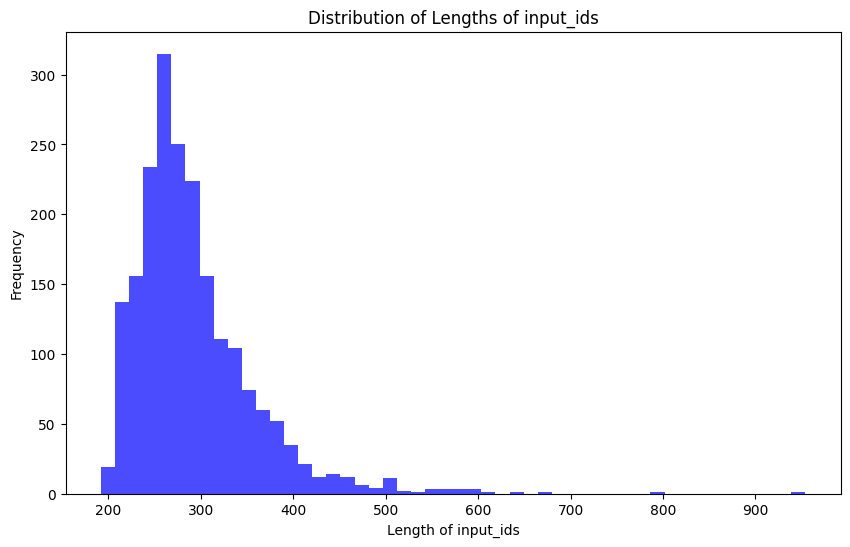

In [49]:
import matplotlib.pyplot as plt

def plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset):
    lengths = [len(x['input_ids']) for x in tokenized_train_dataset]
    lengths += [len(x['input_ids']) for x in tokenized_val_dataset]
    print(len(lengths))

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=50, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    # plt.xlim([0, 1500])
    plt.show()


plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

In [52]:
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training

peft_config = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.1,
    r=16,
    bias="none",
        target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
        "lm_head",
    ],
    task_type="CAUSAL_LM"
)

In [53]:
model = prepare_model_for_kbit_training(model)
model = get_peft_model(model, peft_config)

In [54]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )
print_trainable_parameters(model)

trainable params: 14209024 || all params: 23496810496 || trainable%: 0.06047213940981005


In [55]:
print(model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): PeftModelForCausalLM(
      (base_model): LoraModel(
        (model): MixtralForCausalLM(
          (model): MixtralModel(
            (embed_tokens): Embedding(32000, 4096)
            (layers): ModuleList(
              (0-31): 32 x MixtralDecoderLayer(
                (self_attn): MixtralFlashAttention2(
                  (q_proj): lora.Linear4bit(
                    (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.1, inplace=False)
                    )
                    (lora_A): ModuleDict(
                      (default): Linear(in_features=4096, out_features=16, bias=False)
                    )
                    (lora_B): ModuleDict(
                      (default): Linear(in_features=16, out_features=4096, bias=False)
                    )
                    (lora_embedding_A): ParameterDict()

In [56]:
if torch.cuda.device_count() > 1: # If more than 1 GPU
    print(torch.cuda.device_count())
    model.is_parallelizable = True
    model.model_parallel = True

2


In [59]:
from transformers import TrainingArguments

args = TrainingArguments(
  output_dir = "./Mixtral_45b_SIG_v3",
  #num_train_epochs=5,
  max_steps = 500, # comment out this line if you want to train in epochs
  per_device_train_batch_size = 16,
  warmup_steps = 0.03,
  logging_steps=10,
  save_strategy="epoch",
  #evaluation_strategy="epoch",
  evaluation_strategy="steps",
  eval_steps=10, # comment out this line if you want to evaluate at the end of each epoch
  learning_rate=2.5e-5,
  bf16=True,
  # lr_scheduler_type='constant',
)

In [60]:
from trl import SFTTrainer

max_seq_length = 1024

trainer = SFTTrainer(
  model=model,
  peft_config=peft_config,
  max_seq_length=max_seq_length,
  tokenizer=tokenizer,
  packing=True,
  formatting_func=create_prompt, # this will aplly the create_prompt mapping to all training and test dataset
  args=args,
  train_dataset=dataset,
  eval_dataset=train_test_split['test']
)

In [ ]:
trainer.train()

/home/ubuntu/miniconda3/envs/myenv/lib/python3.8/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss
10,1.352400,1.436042
20,1.159100,1.210535
30,0.983000,1.107445
40,0.911800,1.047539
50,0.854200,1.003148
60,0.820300,0.963458
70,0.790300,0.922513
80,0.762300,0.881547
90,0.694600,0.836425
100,0.658600,0.790172


/home/ubuntu/miniconda3/envs/myenv/lib/python3.8/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/ubuntu/miniconda3/envs/myenv/lib/python3.8/site-packages/peft/utils/save_and_load.py:139: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/home/ubuntu/miniconda3/envs/myenv/lib/python3.8/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default valu

In [ ]:
trainer.save_model("./Mixtral_45b_SIG_es")

In [25]:
from huggingface_hub import notebook_login

In [26]:
notebook_login()

In [27]:
trainer.push_to_hub("meyflex/Mixtral_SIG")

training_args.bin:   0%|          | 0.00/4.73k [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/752M [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [28]:
merged_model = model.merge_and_unload()

/home/ubuntu/miniconda3/envs/myenv/lib/python3.8/site-packages/peft/tuners/lora/bnb.py:325: UserWarning: Merge lora module to 4-bit linear may get different generations due to rounding errors.
  warnings.warn(


In [ ]:
model.eval()
prompt="""[INST] Donnez la description détaillée correspondant au titre suivant.\n Titre: ARC-101 [/INST]"""
print(generate_response(prompt, merged_model))
print("Le code ARC-101 correspond au Retrait de lignes dans la table tampon de l’archivage. Ce traitement permet de supprimer des lignes de la table A_ARC_DONNEE à partir des ID des objets qu'elles représentent.")

In [40]:
messages = [
    {"role": "user", "content": "Donnez la description détaillée correspondant au titre suivant. Titre : ARC-101"},
]
inputs = tokenizer.apply_chat_template(messages, return_tensors="pt").to("cuda")

outputs = merged_model.generate(inputs, max_new_tokens=2000)
print(tokenizer.decode(outputs[0], skip_special_tokens=True))



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[INST] Donnez la description détaillée correspondant au titre suivant. Titre : ARC-101 [/INST] Le titre "ARC-101" est probablement une référence à un type d'article, de produit ou de technologie spécifique. Cependant, sans contexte supplémentaire, il est difficile de fournir une description détaillée précise.

Cela étant dit, "ARC" pourrait être un acronyme pour différentes choses en fonction du domaine d'application. Par exemple, dans le domaine de la technologie de l'information, "ARC" pourrait signifier "Atomic Release Controller", qui est un outil utilisé pour gérer les déploiements de logiciels. Dans ce contexte, "ARC-101" pourrait se référer à une version spécifique de cet outil ou à une fonctionnalité particulière.

Dans le domaine de la chimie, "ARC" pourrait se référer à "Acide Résorcinol-Crotonique", qui est un composé chimique utilisé dans la recherche et l'industrie. "ARC-101" pourrait alors être un nom de code pour une méthode de synthèse ou une application spécifique de c